In [1]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import seaborn as sns
from qtools import Submitter
import glob
from tqdm import tnrange, tqdm_notebook


Goal of this notebook is to see which genes I can run the script on. The criteria is that they have to be genes that correspond to a PacBio isoform (based on the classification.txt file and they have to be a gene with count >0. It also has to be a gene with at least two isoforms. 

In [2]:
working_dir = '/home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/'

In [3]:
data_dir = '/home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/PacBio_genome_scale_RPS2_bugfix'

In [4]:
gene_counts = pd.read_csv('/home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/Pac_NP_counts_compare/countDFeByg.txt', sep = '\t', index_col = 0)

In [5]:
gene_counts.head()

,apobec_PromethION_all.sorted.bam,rps2_PromethION_all.sorted.bam,APO_PacBio_181120_merged.sorted.bam,RPS2_PacBio_181120_merged.sorted.bam
ENSG00000000003.10,706,936,177,180
ENSG00000000005.5,0,0,0,0
ENSG00000000419.8,410,699,16,10
ENSG00000000457.9,200,309,35,58
ENSG00000000460.12,167,307,109,151


In [6]:
gene_counts = gene_counts[['RPS2_PacBio_181120_merged.sorted.bam']]

In [7]:
gene_counts.shape

(57820, 1)

In [8]:
gene_counts = gene_counts[gene_counts['RPS2_PacBio_181120_merged.sorted.bam']>0]

In [9]:
gene_counts.shape

(14330, 1)

In [10]:
hg19_gencode_gtf = pd.read_csv('/home/pjaganna1/genomes/hg19/gencode.v19.annotation.gtf', sep='\t', skiprows=5, header=None)

In [11]:
def get_geneName_from_gtf(row):
    '''populating dictionary with ensemble ID key and gene name value from the provided GTF'''
    ensembl_to_geneName[row[8].split(';')[0].split('\"')[1]] = row[8].split(';')[4].split('\"')[1]
    gene_strand_chrom[row[8].split(';')[4].split('\"')[1]] = [row[6],
                                                              row[0]]  # storing gene and strand info for each gene

In [12]:
ensembl_to_geneName = {}
gene_strand_chrom = {}
hg19_gencode_gtf[hg19_gencode_gtf[2] == 'gene'].apply(get_geneName_from_gtf, axis=1)  # only processing 'gene' rows

0          None
21         None
82         None
92         None
100        None
           ... 
2619425    None
2619430    None
2619433    None
2619438    None
2619441    None
Length: 57820, dtype: object

In [13]:
gene_counts['gene_name'] = gene_counts.index.map(ensembl_to_geneName)

In [14]:
gene_counts.shape

(14330, 2)

In [15]:
gene_counts.head(10)

,RPS2_PacBio_181120_merged.sorted.bam,gene_name
ENSG00000000003.10,180,TSPAN6
ENSG00000000419.8,10,DPM1
ENSG00000000457.9,58,SCYL3
ENSG00000000460.12,151,C1orf112
ENSG00000001036.9,184,FUCA2
ENSG00000001084.6,64,GCLC
ENSG00000001167.10,34,NFYA
ENSG00000001460.13,40,STPG1
ENSG00000001461.12,109,NIPAL3
ENSG00000001497.12,193,LAS1L


In [16]:
gene_counts[gene_counts['gene_name']=='ZNF521']

,RPS2_PacBio_181120_merged.sorted.bam,gene_name
ENSG00000198795.6,16,ZNF521


In [17]:
classification_info = pd.read_csv(os.path.join(working_dir, '../rps2_isoform.collapsed_classification.txt'), sep='\t')
classification_info_subset = classification_info[['isoform', 'chrom', 'associated_gene']]
classification_info_subset['gene_name'] = classification_info_subset['associated_gene'].map(
        ensembl_to_geneName).fillna(classification_info_subset['associated_gene'])

/home/pjaganna1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [18]:
gene_list = []
for i in set(classification_info_subset['gene_name'].tolist()):
    if str(i) != 'nan':
        if ('novelGene' not in i) and ('ENSG' not in i):
            gene_list.append(i)

In [19]:
len(gene_list)

14750

In [20]:
common_genes = set(gene_list).intersection(set(gene_counts['gene_name'].tolist()))

In [21]:
classification_info_subset.head()

,isoform,chrom,associated_gene,gene_name
0,PB.1.1,chr1,ENSG00000227232.4,WASH7P
1,PB.1.10,chr1,ENSG00000227232.4,WASH7P
2,PB.1.11,chr1,ENSG00000227232.4,WASH7P
3,PB.1.12,chr1,ENSG00000227232.4,WASH7P
4,PB.1.13,chr1,ENSG00000227232.4,WASH7P


In [22]:
###This step takes a while 
final_gene_list = []
for gene in common_genes:
    if len(classification_info_subset[classification_info_subset['gene_name']==gene]['isoform'].tolist()) >=2:
        final_gene_list.append(gene)

In [23]:
len(final_gene_list)

11736

In [24]:
final_gene_list

['KIAA0319L',
 'DNAJC4',
 'MAP4K2',
 'AKAP9',
 'ORMDL1',
 'ARAF',
 'IFT20',
 'CLDND1',
 'ATP9A',
 'ZDHHC23',
 'PQLC1',
 'MRPL20',
 'INTS2',
 'CDIP1',
 'PPARG',
 'COL5A1',
 'ELP4',
 'PATL1',
 'CNTNAP2',
 'KLHL11',
 'ZYG11A',
 'MARS2',
 'GRSF1',
 'GNL1',
 'RP11-613M10.6',
 'RP11-390E23.6',
 'SLC16A9',
 'MATN2',
 'CAAP1',
 'ATP11B',
 'EIF3E',
 'RNF26',
 'USP38',
 'MRPS34',
 'CA2',
 'CEP85',
 'ZNF681',
 'WBP5',
 'CTC-480C2.1',
 'DPH7',
 'PSTK',
 'ELOF1',
 'ZNF562',
 'ITPR2',
 'CRYZL1',
 'RAET1K',
 'MBOAT7',
 'GRAMD1A',
 'ILKAP',
 'IPP',
 'ARCN1',
 'LINC00338',
 'HOXC11',
 'MNX1-AS1',
 'KPNB1',
 'TCEA2',
 'LOXL1',
 'MCL1',
 'RAB5CP2',
 'KIF1B',
 'RDH11',
 'LMOD1',
 'ANKRD32',
 'STAU1',
 'SGCB',
 'CORO6',
 'ZNF672',
 'LCORL',
 'VPS37A',
 'DHRS12',
 'MRPL48',
 'BNIP2',
 'CEP95',
 'TRIM41',
 'CDC23',
 'DHRS4',
 'RP11-253E3.3',
 'MYO19',
 'CAPN10',
 'GNPAT',
 'CLIP2',
 'ITGB1BP1',
 'CHD4',
 'VCPKMT',
 'BTN2A3P',
 'CRIPT',
 'CSNK1D',
 'ZFAND4',
 'SERINC5',
 'RP11-398K22.12',
 'CPNE3',
 'HINFP',


In [25]:
############Don't run this again###################################################
###################################################################################
#def make_chunks(list_to_chunk, size):
chunk1 = len(final_gene_list)//24
chunk2 = chunk1//5

count = 1
for g in range(0, len(final_gene_list), chunk1):
    if g+chunk1 > len(final_gene_list)==True:
        list_chunk = final_gene_list[g:]
    else:
        list_chunk = final_gene_list[g:g+chunk1]
    cmds = []
    for y in range(0, len(list_chunk), 5):
        if y+5 > len(list_chunk) == True:
            sub_list_chunk = list_chunk[y:]
        else:
            sub_list_chunk = list_chunk[y:y+5]
        
        cmd = ['module load python3essential']
        for each in sub_list_chunk:
            cmd.append('python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/ ' + each)
        cmds.append(';'.join(cmd))
    #Submitter(cmds, 'rps2_pacbio_quant_chunk_' + str(count) , nodes=1, ppn=2, walltime='48:00:00', array=True, submit=False)
    count += 1
    print('\n'.join(cmds))
    print('\n')
    print('\n')

Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_1.sh.
Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_2.sh.
Writing 98 tasks as an array-job.


module load python3essential;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/ CALCB;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/ PI4K2B;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/ U91328.19;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_re

Wrote commands to rps2_pacbio_quant_chunk_3.sh.
Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_4.sh.
Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_5.sh.
Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_6.sh.
Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_7.sh.
Writing 98 tasks as an array-job.


module load python3essential;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/ FAM213B;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/ KLHL15;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/ C1QTNF6;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_re

Wrote commands to rps2_pacbio_quant_chunk_8.sh.
Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_9.sh.
Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_10.sh.
Writing 98 tasks as an array-job.


module load python3essential;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/ ZNF391;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/ AC000068.5;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/ GIN1;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_re

Wrote commands to rps2_pacbio_quant_chunk_11.sh.
Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_12.sh.
Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_13.sh.
Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_14.sh.
Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_15.sh.
Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_16.sh.


module load python3essential;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/ OPN3;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/ PPP2R2D;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/ LCA5L;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_

Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_17.sh.
Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_18.sh.
Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_19.sh.
Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_20.sh.
Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_21.sh.
Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_22.sh.


module load python3essential;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/ GALNS;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/ C14orf1;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/ GAL;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_q

module load python3essential;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/ SASH1;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/ LCORL;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_quantification/ MAML1;python3 /home/pjaganna1/scratch/PacBio_genome_scale_RPS2_bugfix/submitter_script/genome-wide-pac-RPS2-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/RPS2_isoform_edits/percent_edited_reads_q

Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_23.sh.
Writing 98 tasks as an array-job.
Wrote commands to rps2_pacbio_quant_chunk_24.sh.


In [25]:
chunk1 = len(final_gene_list)//24
gene_chunks = {}
count = 1
for g in range(0, len(final_gene_list), chunk1):
    if g+chunk1 > len(final_gene_list)==True:
        list_chunk = final_gene_list[g:]
    else:
        list_chunk = final_gene_list[g:g+chunk1]
    chunk_name = 'chunk_' + str(count)
    gene_chunks[chunk_name] = list_chunk
    count +=1

In [26]:
gene_chunks

{'chunk_1': ['KIAA0319L',
  'DNAJC4',
  'MAP4K2',
  'AKAP9',
  'ORMDL1',
  'ARAF',
  'IFT20',
  'CLDND1',
  'ATP9A',
  'ZDHHC23',
  'PQLC1',
  'MRPL20',
  'INTS2',
  'CDIP1',
  'PPARG',
  'COL5A1',
  'ELP4',
  'PATL1',
  'CNTNAP2',
  'KLHL11',
  'ZYG11A',
  'MARS2',
  'GRSF1',
  'GNL1',
  'RP11-613M10.6',
  'RP11-390E23.6',
  'SLC16A9',
  'MATN2',
  'CAAP1',
  'ATP11B',
  'EIF3E',
  'RNF26',
  'USP38',
  'MRPS34',
  'CA2',
  'CEP85',
  'ZNF681',
  'WBP5',
  'CTC-480C2.1',
  'DPH7',
  'PSTK',
  'ELOF1',
  'ZNF562',
  'ITPR2',
  'CRYZL1',
  'RAET1K',
  'MBOAT7',
  'GRAMD1A',
  'ILKAP',
  'IPP',
  'ARCN1',
  'LINC00338',
  'HOXC11',
  'MNX1-AS1',
  'KPNB1',
  'TCEA2',
  'LOXL1',
  'MCL1',
  'RAB5CP2',
  'KIF1B',
  'RDH11',
  'LMOD1',
  'ANKRD32',
  'STAU1',
  'SGCB',
  'CORO6',
  'ZNF672',
  'LCORL',
  'VPS37A',
  'DHRS12',
  'MRPL48',
  'BNIP2',
  'CEP95',
  'TRIM41',
  'CDC23',
  'DHRS4',
  'RP11-253E3.3',
  'MYO19',
  'CAPN10',
  'GNPAT',
  'CLIP2',
  'ITGB1BP1',
  'CHD4',
  'VCPKMT',


In [27]:
[len(gene_chunks[i]) for i in gene_chunks]

[489,
 489,
 489,
 489,
 489,
 489,
 489,
 489,
 489,
 489,
 489,
 489,
 489,
 489,
 489,
 489,
 489,
 489,
 489,
 489,
 489,
 489,
 489,
 489]

Checking that all files for all genes have something in them.

In [28]:
for gene in tqdm(final_gene_list):
    if os.path.exists(data_dir + '/' + gene + '_quantification_output.txt') ==True:
        if os.path.getsize(data_dir + '/' + gene + '_quantification_output.txt') == 0:
            print('File for {} is empty'.format(gene))
    else:
        print('File for {} does not exist'.format(gene))

 38%|███▊      | 4428/11736 [00:01<00:02, 3289.86it/s]

File for RBL1 does not exist


 44%|████▎     | 5107/11736 [00:01<00:01, 3342.78it/s]

File for ZNF668 does not exist


 80%|████████  | 9417/11736 [00:02<00:00, 3288.08it/s]

File for U1 does not exist


 91%|█████████▏| 10736/11736 [00:03<00:00, 3290.81it/s]

File for CKS1B does not exist
File for VAMP7 does not exist


100%|██████████| 11736/11736 [00:03<00:00, 3313.29it/s]

File for MRPS25 does not exist
File for DHRS4-AS1 does not exist
File for KBTBD4 does not exist


In [29]:
genome_wide_gene = []
genome_wide_isoA = []
genome_wide_isoB = []
genome_wide_bins = []
for c in gene_chunks:
    print('Processing {}'.format(c))
    for gene in tqdm(gene_chunks[c]):
        if os.path.exists(data_dir + '/' + gene + '_quantification_output.txt') ==True:
            df = pd.read_csv(os.path.join(data_dir, gene + '_quantification_output.txt'), sep = '\t')
            if len(df) >1:
                df = df.sort_values('num_reads', ascending = False).iloc[:2,:]
                if len(df.dropna()) > 1:
                    if df.iloc[0,5]>=10 and df.iloc[1,5]>=10:
                        if df.iloc[0]['num_reads']/df.iloc[1]['num_reads']<=5:
                            genome_wide_gene.append(gene)
                            bins = [str(b) for b in df['bin'].tolist()]
                            genome_wide_bins.append(','.join(bins))
                            genome_wide_isoA.append(df.iloc[0]['percent reads edited'])
                            genome_wide_isoB.append(df.iloc[1]['percent reads edited'])
        

  2%|▏         | 10/489 [00:00<00:05, 94.81it/s]

Processing chunk_1


  2%|▏         | 10/489 [00:00<00:05, 92.23it/s]

Processing chunk_2


  3%|▎         | 14/489 [00:00<00:03, 132.35it/s]

Processing chunk_3


  3%|▎         | 14/489 [00:00<00:03, 134.48it/s]

Processing chunk_4


  2%|▏         | 9/489 [00:00<00:05, 84.93it/s]

Processing chunk_5


  3%|▎         | 13/489 [00:00<00:03, 122.57it/s]

Processing chunk_6


  3%|▎         | 13/489 [00:00<00:03, 121.17it/s]

Processing chunk_7


  3%|▎         | 15/489 [00:00<00:03, 138.69it/s]

Processing chunk_8


  3%|▎         | 13/489 [00:00<00:03, 123.13it/s]

Processing chunk_9


  3%|▎         | 14/489 [00:00<00:03, 131.21it/s]

Processing chunk_10


  3%|▎         | 16/489 [00:00<00:03, 157.30it/s]

Processing chunk_11


  3%|▎         | 13/489 [00:00<00:03, 123.23it/s]

Processing chunk_12


  2%|▏         | 8/489 [00:00<00:06, 79.34it/s]

Processing chunk_13


  3%|▎         | 13/489 [00:00<00:03, 124.69it/s]

Processing chunk_14


  3%|▎         | 13/489 [00:00<00:03, 128.48it/s]

Processing chunk_15


  3%|▎         | 13/489 [00:00<00:03, 129.71it/s]

Processing chunk_16


  3%|▎         | 14/489 [00:00<00:03, 137.42it/s]

Processing chunk_17


  3%|▎         | 13/489 [00:00<00:03, 121.78it/s]

Processing chunk_18


  3%|▎         | 13/489 [00:00<00:03, 122.16it/s]

Processing chunk_19


  3%|▎         | 13/489 [00:00<00:03, 125.88it/s]

Processing chunk_20


  3%|▎         | 14/489 [00:00<00:03, 135.71it/s]

Processing chunk_21


  2%|▏         | 12/489 [00:00<00:04, 114.11it/s]

Processing chunk_22


  2%|▏         | 9/489 [00:00<00:05, 87.46it/s]

Processing chunk_23


  3%|▎         | 13/489 [00:00<00:03, 128.44it/s]

Processing chunk_24


100%|██████████| 489/489 [00:03<00:00, 125.66it/s]


In [30]:
table=pd.DataFrame({'Gene':genome_wide_gene, 'bins':genome_wide_bins, 'IsoA': genome_wide_isoA, 'IsoB': genome_wide_isoB})

In [31]:
table = table.set_index('Gene')

In [32]:
table.shape

(1994, 3)

In [33]:
table.head()

,bins,IsoA,IsoB
Gene,,,
KIAA0319L,"2,3",0.082474,0.033333
ORMDL1,"6,8",0.258065,0.037736
GRSF1,"3,4",0.135593,0.260870
SLC16A9,"1,2",0.166667,0.100000
CAAP1,"6,5",0.575000,0.434783


In [34]:
table.to_csv(os.path.join(working_dir, 'RPS2_genome_scale_pacbio_percent_edited_reads_bugfix.txt'), sep = '\t')

In [35]:
table['dif'] = table['IsoA']-table['IsoB']

In [36]:
table = table.sort_values('dif', ascending = False)

In [38]:
table.tail()

,bins,IsoA,IsoB,dif
Gene,,,,
COL4A3BP,"11,2",0.000000,0.454545,-0.454545
FOXP1,"7,2",0.018182,0.500000,-0.481818
ZBTB41,"8,0",0.100000,0.727273,-0.627273
NBPF1,"5,0",0.000000,0.666667,-0.666667
GPSM2,"7,8",0.195122,1.000000,-0.804878


In [110]:
table[table.index=='CSDE1']

,bins,IsoA,IsoB,dif,strand,filter
Gene,,,,,,
CSDE1,"2,3",0.231142,0.20125,0.029892,-,1


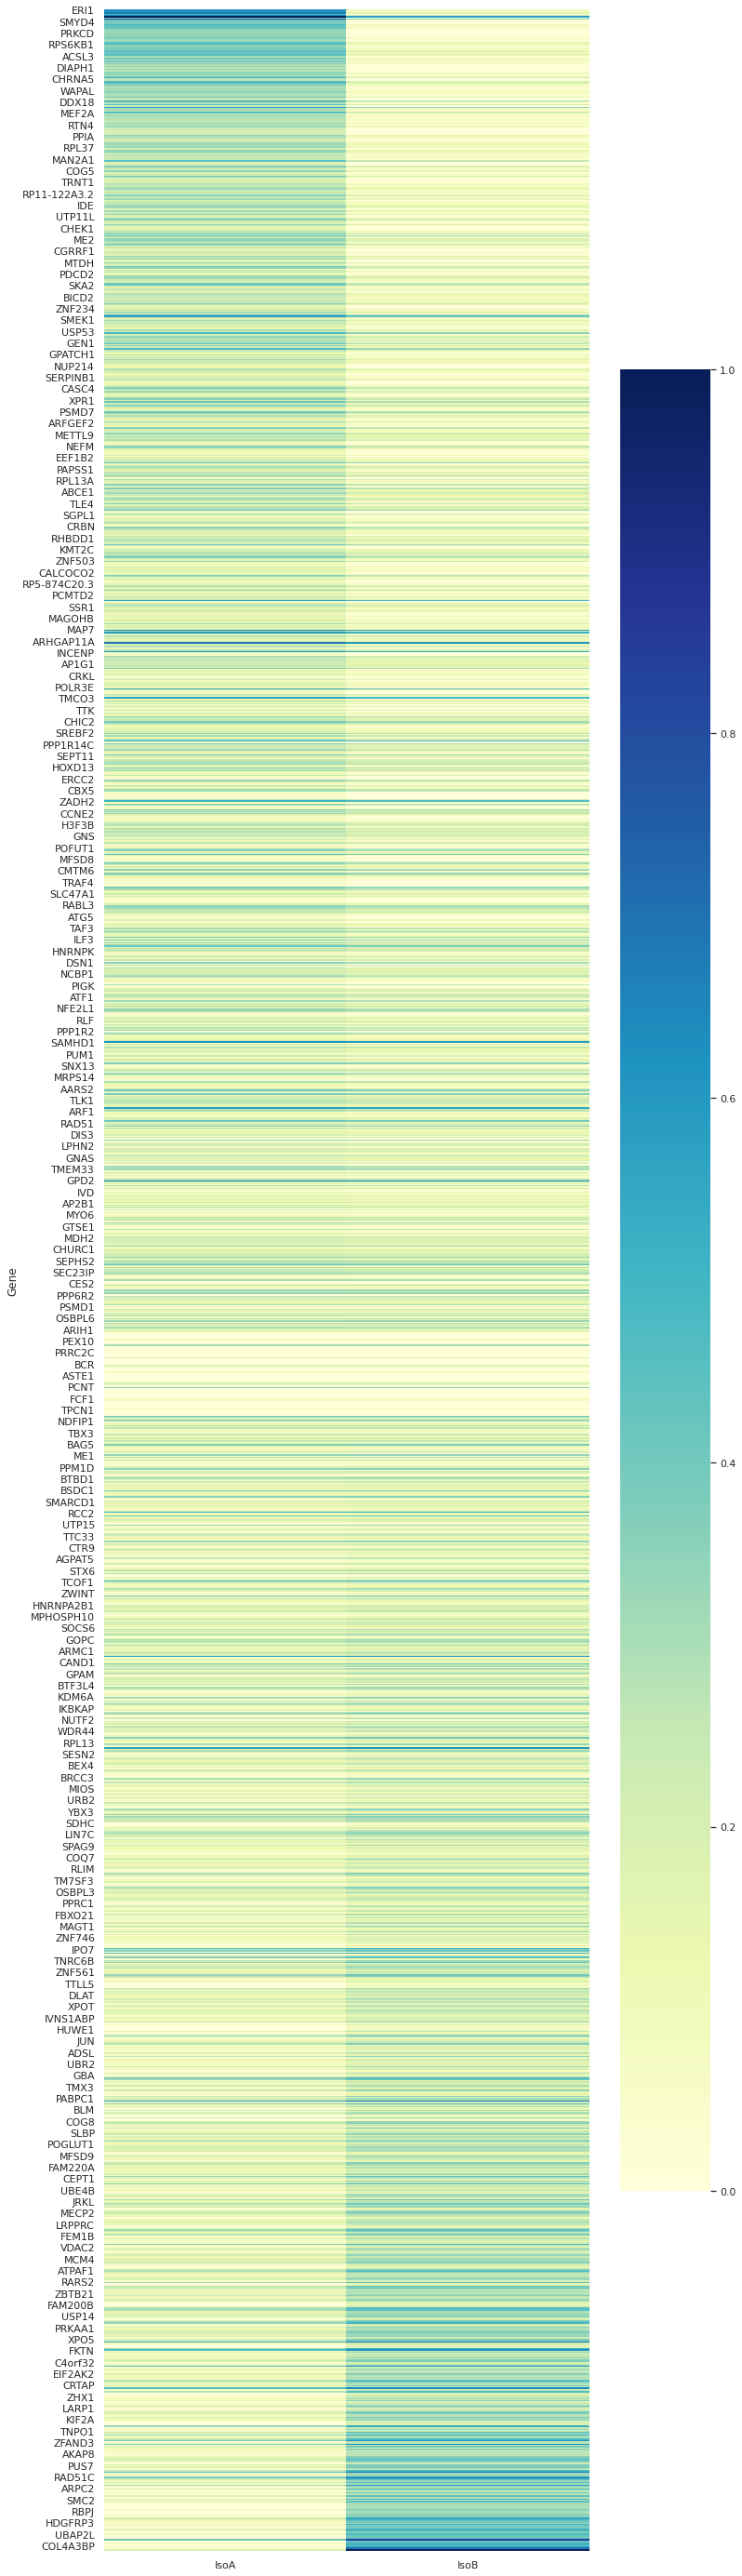

In [40]:
sns.set(rc={'figure.figsize':(11.7,50.27)})
ax = sns.heatmap(table[['IsoA', 'IsoB']],cmap="YlGnBu")
plt.savefig(os.path.join(working_dir,'RPS2_heatmap.png'))
plt.savefig(os.path.join(working_dir,'RPS2_heatmap.svg'))

In [106]:
table[table.index=='APP']

,bins,IsoA,IsoB,dif
Gene,,,,
APP,"1,4",0.511111,0.304348,0.206763


In [95]:
k_list = ['PIGN','MAP3K7','SYNCRIP', 'QKI', 'HNRNPK', 'TIA1', 'EIF4EBP2', 'HNRNPC', 'USP34', 'FMR1', 'SLC25A32', 'RPN1', 'PLAGL1', 'HNRNPA3', 'FAR1', 'U2SURP', 'CHTOP']

In [96]:
len(k_list)

17

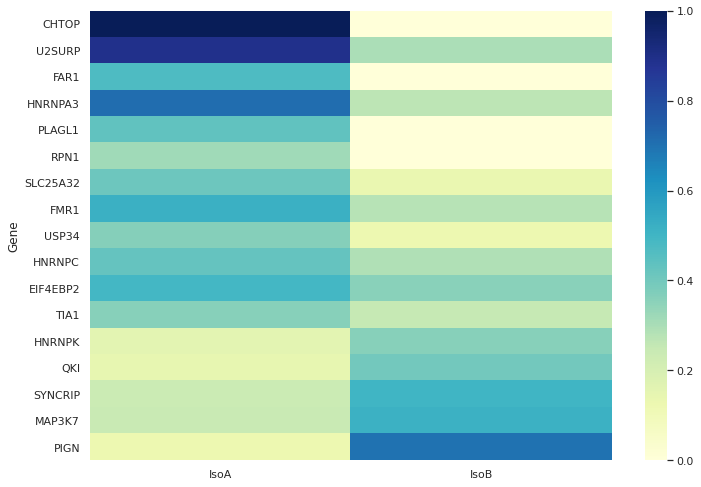

In [103]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(table[table.index.isin(k_list)].sort_values('dif', ascending = False)[['IsoA', 'IsoB']],cmap="YlGnBu")


In [57]:
table_subset_countcutoff50 = table[table.index.isin(gene_counts[gene_counts['RBFOX_PacBio_181120_merged.sorted.bam']>20]['gene_name'].tolist())]

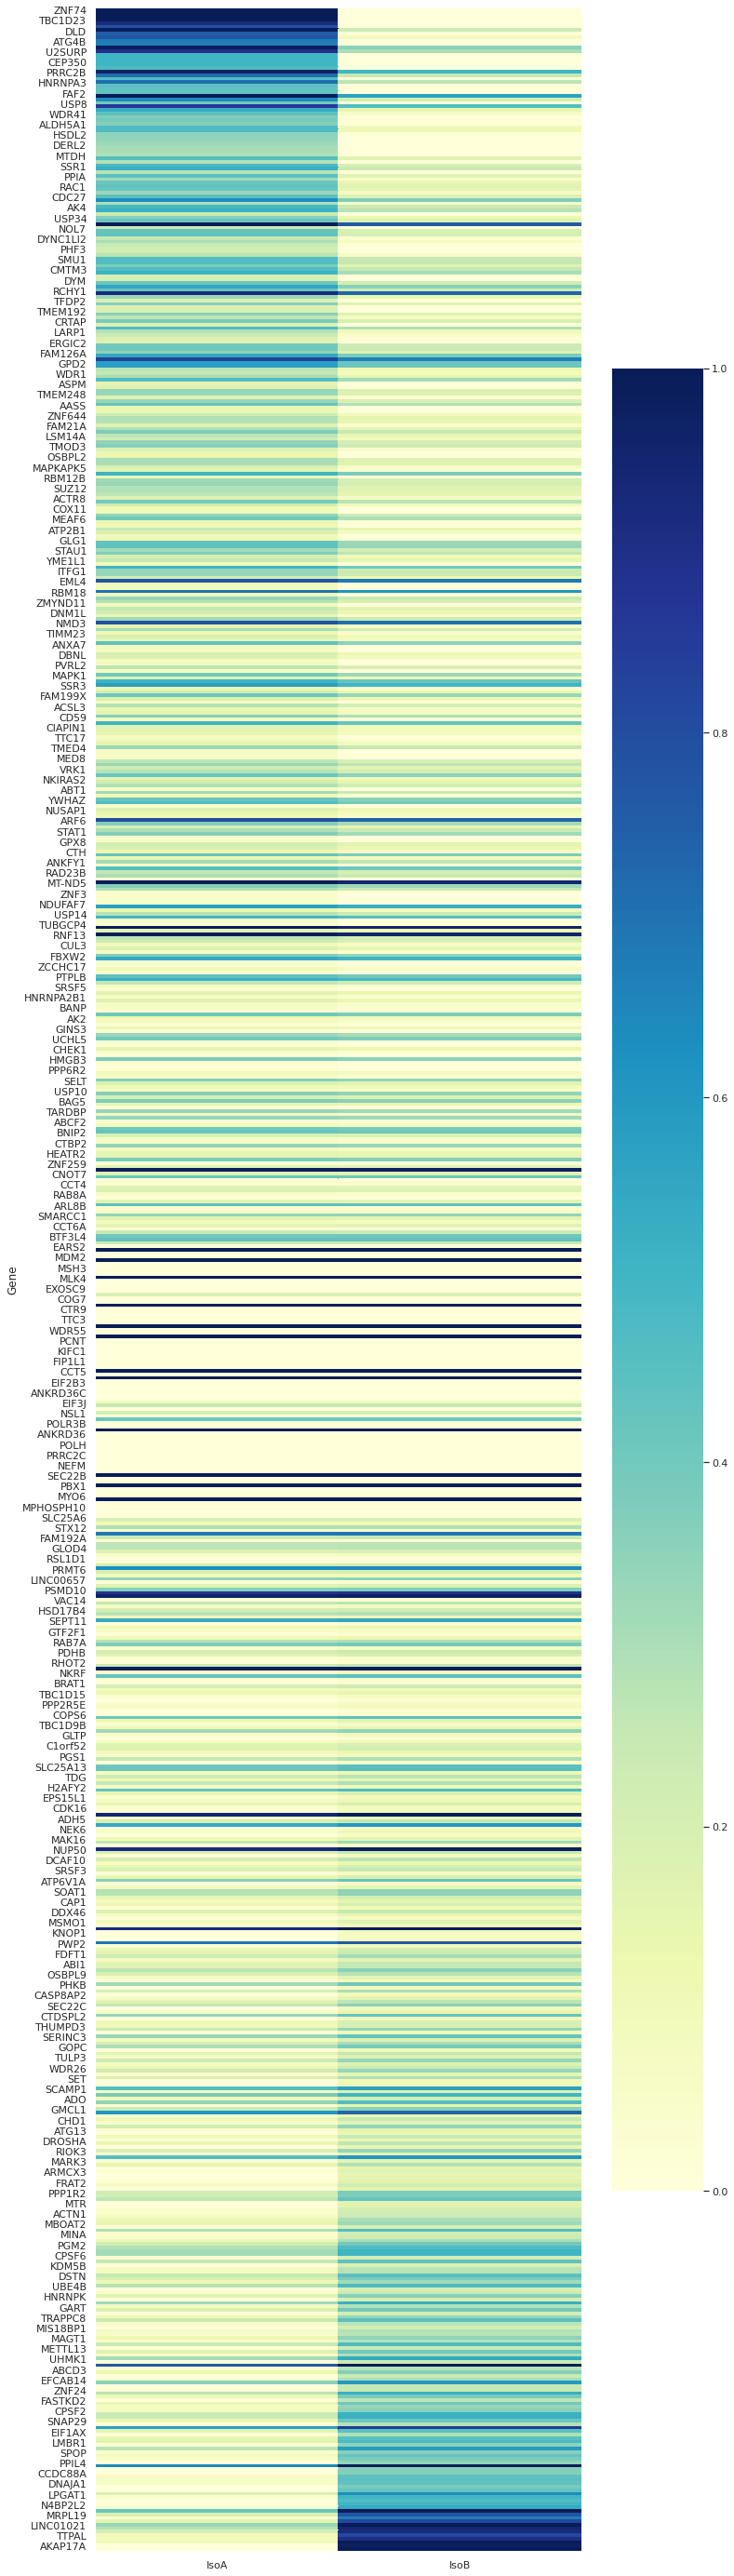

In [58]:
sns.set(rc={'figure.figsize':(11.7,50.27)})
ax = sns.heatmap(table_subset_countcutoff50[['IsoA', 'IsoB']],cmap="YlGnBu")

In [59]:
table_subset_countcutoff50[table_subset_countcutoff50['Gene']=='FAR1']

KeyError: 'Gene'

In [75]:
df.loc[0]['num_reads']/df.loc[1]['num_reads']

1.0

In [76]:
df

,bin,percent reads edited,START,FINISH,reads,num_reads
0,0,NaN,5628094,5628104,['m54329U_200731_232621/149815784/ccs'],1
1,3,NaN,5662993,5663003,['m54329U_200731_232621/94045019/ccs'],1
2,4,NaN,5668424,5668434,['m54329U_200731_232621/31590264/ccs'],1
3,5,0.013423,5668472,5668493,"['m54329U_200804_223650/40830492/ccs', 'm54329...",149


In [79]:
df_test = df.sort_values('num_reads', ascending = False).iloc[:2,:]

In [80]:
df_test

,bin,percent reads edited,START,FINISH,reads,num_reads
3,5,0.013423,5668472,5668493,"['m54329U_200804_223650/40830492/ccs', 'm54329...",149
0,0,NaN,5628094,5628104,['m54329U_200731_232621/149815784/ccs'],1


In [83]:
df_test.iloc[0]['num_reads']/df_test.iloc[1]['num_reads'] < 5

False

In [86]:
df_test.iloc[1]

bin                                                           0
percent reads edited                                        NaN
START                                                   5628094
FINISH                                                  5628104
reads                   ['m54329U_200731_232621/149815784/ccs']
num_reads                                                     1
Name: 0, dtype: object